
# Red Ventures — Data Science Technical Case

**Author:** Gregory Yampolsky  
**Date:** 2025-08-21

Hi.

I'm Greg and welcome to my notebook!  This notbook will answer all questions and parts of the Red Ventures take home assignment.  Hopefully it will give you insight into how I structure my experiments when only given a few hours to complete them.  Normally I would set up a pipeline in a notebook like this one as to perform EDA and experiment with different preprocessing, sampling, and modeling setups, but once I find which model works I would normally productionize the code into a repository and create any graphs with other software tools like powerpoint, excel, tabeleau.

I apologize if my notebook is too long, but I wanted to make sure that my experiments and answers were thorough.  If you have any questions please reach out to me at gregyampolsky@gmail.com

## Part 1
Build a model to predict probability of call to action click


### Import libraries

In [1]:
pip install category_encoders

In [24]:
# imports

# Standard library
import ast
import os
import pickle
import re
import sys
import textwrap
import time
from time import time

# Third-party
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, spearmanr, ttest_ind

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# scikit-learn
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.metrics import (
    average_precision_score,
    brier_score_loss,
    log_loss,
    precision_recall_curve,
    PrecisionRecallDisplay,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Encoders
from category_encoders import TargetEncoder

# Reproducibility & display
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 200)



### 1. Read csv and sanity checks

I chose to make this notebook in google colab to take advantage of the more powerful computes they offer on the cloud as well as to more seamlessly integrate my notebook with my google drive.

If you would like to run this on a local instead please replace how you read the csv.


In [3]:

#read the csv
from google.colab import drive
GDRIVE_FOLDER = "/content/drive/MyDrive/Colab Notebooks/"#change folder path specific to your organization
df = pd.read_csv(GDRIVE_FOLDER+'/train.csv') #comment out if on local/ change folder path to match your structure.
#df = pd.read_csv(<file location on local>)    <-use this instead of the two lines above if youre running on local instead of google colab.
print(df.shape)
df.head()

(100000, 18)


,date,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrollDepth,clickedCTA,submittedForm,scheduledAppointment,mortgageVariation,revenue
0,9/1/24,user_97048,Google,Safari,Mobile,152000.0,Apartment,1,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",75,0,0,0,NaN,NaN
1,9/1/24,user_14393,Social,Safari,Mobile,140000.0,Apartment,2,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,25,0,0,0,NaN,NaN
2,9/1/24,user_30959,Direct,Safari,Mobile,128000.0,House,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,75,0,0,0,NaN,NaN
3,9/1/24,user_88588,Google,Chrome,Mobile,205000.0,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,75,1,1,0,NaN,NaN
4,9/1/24,user_65965,Google,Safari,Mobile,NaN,House,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,0,0,0,0,NaN,NaN


If `clickedCTA` is our target column then we will have to drop `submittedForm`, `scheduledAppointment`, and `revenue` when training our model as those columns contain information about the target column.



**Checking for any null values**

In [4]:

# Basic schema / nulls / target prevalence
df.info()
print("\nNulls per column:\n", df.isna().sum().sort_values(ascending=False))

target_col = "clickedCTA"  # as specified in the case


ctr = df[target_col].mean()
print(f"\nBaseline CTR (mean of {target_col}): {ctr:.4f}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   100000 non-null  object 
 1   userId                 100000 non-null  object 
 2   sessionReferrer        100000 non-null  object 
 3   browser                100000 non-null  object 
 4   deviceType             100000 non-null  object 
 5   estimatedAnnualIncome  79986 non-null   float64
 6   estimatedPropertyType  100000 non-null  object 
 7   visitCount             100000 non-null  int64  
 8   pageURL                100000 non-null  object 
 9   ctaCopy                100000 non-null  object 
 10  ctaPlacement           100000 non-null  object 
 11  editorialSnippet       100000 non-null  object 
 12  scrollDepth            100000 non-null  int64  
 13  clickedCTA             100000 non-null  int64  
 14  submittedForm          100000 non-nul

**checking for duplicates**

In [5]:
# Duplicate checks: rows & userId

# 1) Exact duplicate rows (all columns identical)
dup_row_mask = df.duplicated(keep=False)
print(f"Duplicate rows (including first occurrences): {int(dup_row_mask.sum())}")
if dup_row_mask.any():
    print("Showing up to 10 duplicate rows:")
    display(df[dup_row_mask].head(10))

# 2) Duplicate userId occurrences
user_id_col = 'userId'
vc = df[user_id_col].value_counts(dropna=False)
dupe_ids = vc[vc > 1]
print(f"\nUnique IDs appearing more than once: {int(dupe_ids.shape[0])}")
if not dupe_ids.empty:
    print(f"Max repeats for a single ID: {int(dupe_ids.max())}")
    print("\nTop repeated IDs (count):")
    display(dupe_ids.head(20).to_frame("count"))

    print("\nSample rows for repeated IDs:")
    sample = df[df[user_id_col].isin(dupe_ids.index)].sort_values(user_id_col).head(20)
    display(sample)

# Quick summary stats
extra_rows_beyond_first = int(df.duplicated(subset=[user_id_col]).sum())
print(f"\nRows beyond first occurrences for repeated IDs: {extra_rows_beyond_first}")


Duplicate rows (including first occurrences): 0

Unique IDs appearing more than once: 0

Rows beyond first occurrences for repeated IDs: 0


Fortunately there were no duplicates but there were many missing entries for income.  

### 2. Exploratory Data Analysis

**Cat columns EDA**
Number of unique features in each categorical column

In [6]:
# Unique values for key categorical columns
cat_cols = ["sessionReferrer", "browser", "deviceType", "estimatedPropertyType"]

# Summary: number of unique values per column
summary = {
    col: (df[col].nunique(dropna=True) if col in df.columns else None)
    for col in cat_cols
}
print("Number of unique categories of each cat column:")
display(pd.DataFrame.from_dict(summary, orient="index", columns=["n_unique"]))


Number of unique categories of each cat column:


,n_unique
sessionReferrer,4
browser,4
deviceType,2
estimatedPropertyType,4


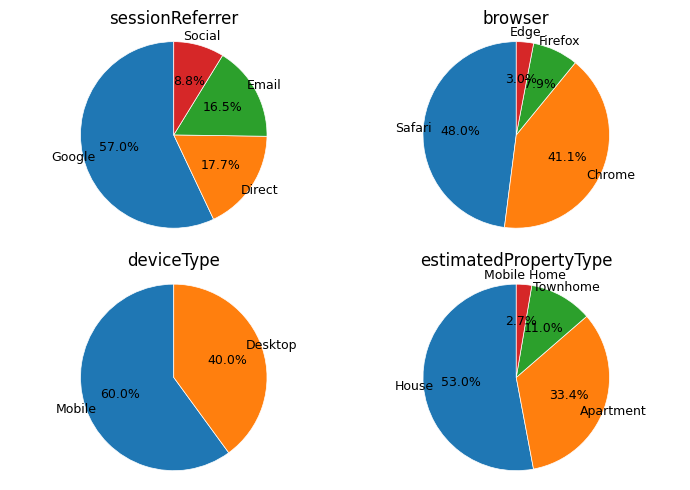

In [7]:
# creating pie charts to show distributions of categories


top_n = 8  # max distinct labels per pie (rest grouped into "Other")
# function to group anything past top_n as other
def topn_with_other(series, top_n=8):
    feature_categories = series.fillna("(missing)").astype(str).value_counts()
    if feature_categories.shape[0] > top_n:
        top = feature_categories.head(top_n - 1)  # reserve a slot for "Other"
        other = feature_categories.iloc[top_n - 1:].sum()
        feature_categories = top.copy()
        feature_categories.loc["Other"] = other
    return feature_categories

# for 4 features make 2 rows of 2 pie charts
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    feature_categories = topn_with_other(df[col], top_n=top_n)
    ax = axes[i]
    ax.pie(
        feature_categories.values,
        labels=feature_categories.index,
        autopct=lambda p: f"{p:.1f}%",
        startangle=90,
        wedgeprops=dict(linewidth=0.5, edgecolor="white"),
        textprops=dict(ha="center", va="center", fontsize=9)
    )
    ax.set_title(col)
    ax.axis("equal")  # circles

plt.tight_layout()
plt.show()

**Time series EDA**

/tmp/ipython-input-4030916998.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d['date'] = pd.to_datetime(d['date'], errors="coerce")


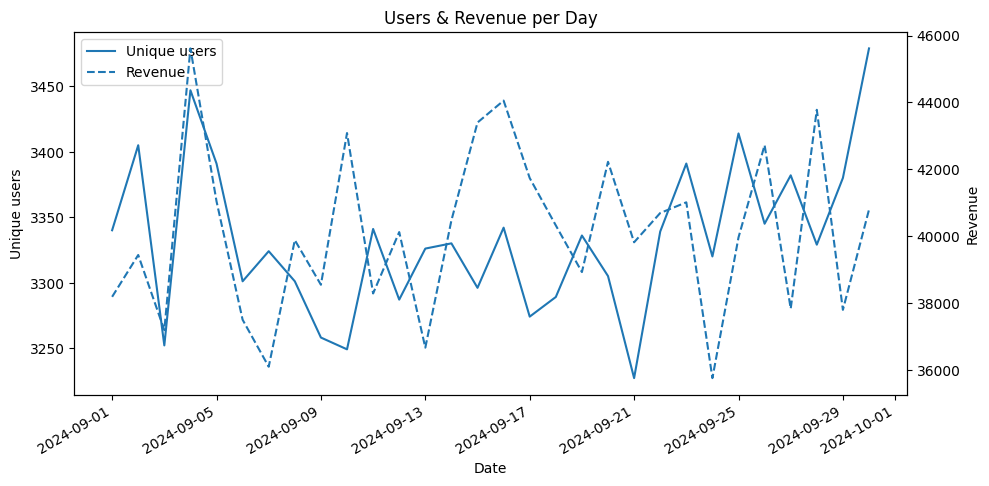

In [8]:
# Time series: total unique users and total revenue per date (overlay)

# --- Prep & aggregate daily ---
d = df.copy()
d['date'] = pd.to_datetime(d['date'], errors="coerce")
d = d.dropna(subset=['date'])
d["date"] = d['date'].dt.normalize()

# unique users per day
ts_users = d.groupby("date")['userId'].nunique().rename("unique_users")

# total revenue per day (0 if all values that day are null)
d['revenue'] = pd.to_numeric(d['revenue'], errors="coerce")  # don't fill here
ts_rev = (
    d.groupby("date")['revenue']
      .sum(min_count=1)   # NaN if all entries are NaN
      .fillna(0)          # turn those all-NaN days into 0
      .rename("revenue")
)

# align indices
idx = ts_users.index.union(ts_rev.index)
ts_users = ts_users.reindex(idx, fill_value=0)
ts_rev = ts_rev.reindex(idx, fill_value=0)

# --- Plot overlay with secondary y-axis ---
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(idx, ts_users.values, label="Unique users")
ax1.set_xlabel("Date")
ax1.set_ylabel("Unique users")

ax2 = ax1.twinx()
ax2.plot(idx, ts_rev.values, linestyle="--", label="Revenue")
ax2.set_ylabel("Revenue")

# Combined legend
lines, labels = [], []
for ax in (ax1, ax2):
    lns, lbs = ax.get_legend_handles_labels()
    lines += lns; labels += lbs
ax1.legend(lines, labels, loc="upper left")

plt.title("Users & Revenue per Day")
plt.tight_layout()

plt.gcf().autofmt_xdate()

Since the dates only span one month I think it would be wise to convert them to days of the week. From my experience things like CTR are often correlated to DOW as people might spend more on a friday when they get their paychecks.


**Longer text EDA**

In [9]:
#unique pageurl

base = "https://www.financialservices.com/mortgages/"

s = (
    df["pageURL"]
    .dropna()
    .astype(str)
    .str.replace("^" + re.escape(base), "", regex=True)  # remove only if at the start
)
display(
    s.value_counts()
     .rename("count")
     .to_frame()
     .reset_index()
     .rename(columns={"index": "path_after_prefix_removed"})
)

#unique editorial snippets
display(
    df['editorialSnippet'].value_counts()
     .rename("count")
     .to_frame()
     .reset_index()
     .rename(columns={"index": "editorialSnippet"})
)

,pageURL,count
0,how-to-get-the-best-mortgage-rate,10166
1,mortgage-calculator,10145
2,best-mortgage-lenders,10084
3,30-year-mortgage-rates,10007
4,types-of-mortgages,9988
5,what-is-mortgage,9970
6,refinance-rates,9961
7,reviews,9905
8,apply,9894
9,first-time-homebuyer-guide,9880


,editorialSnippet,count
0,From improving your credit score to timing you...,3446
1,Take control of your mortgage journey with our...,3435
2,Understand how market fluctuations impact long...,3424
3,Discover the top mortgage lenders of the year....,3415
4,Equip yourself with knowledge. Understand the ...,3385
5,Explore the different types of mortgages avail...,3382
6,Our mortgage calculator is a powerful tool for...,3381
7,Our tools help you assess whether refinancing ...,3367
8,Discover what sets top mortgage lenders apart....,3366
9,"Compare rates, customer service, and loan opti...",3355


In [10]:
# checking the number of unique words in the editorial snippets column as to help decide if we should use tf-idf for encoding

# tokenize: keep letters/numbers/apostrophes, lowercase
pattern = r"[a-z0-9']+"
s = df['editorialSnippet'].dropna().astype(str).str.lower()

# explode to one token per row
words = s.str.findall(pattern).explode().dropna()

# unique, sorted
unique_words = np.sort(words.unique())
print(f"Unique words: {len(unique_words)}")

# peek
print('first 50:\n', unique_words[:50])  # first 50 alphabetically

# Show as a dataframe
display(pd.DataFrame({"word": unique_words}))

Unique words: 264
first 50:
 ['30' 'a' 'about' 'accurate' 'actionable' 'addressing' 'adjustable'
 'advantage' 'affect' 'aligns' 'an' 'analyses' 'and' 'apart' 'application'
 'are' 'as' 'assess' 'available' 'backed' 'basics' 'benefits' 'best'
 'borrower' 'borrowing' 'break' 'budget' 'budgeting' 'build' 'buyers'
 'buying' 'by' 'calculate' 'calculator' 'can' 'changes' 'choice' 'choose'
 'circumstances' 'clarifying' 'clarity' 'clear' 'closing' 'compare'
 'competitiveness' 'compiled' 'complexities' 'comprehensive' 'concepts'
 'confidence']


,word
0,30
1,a
2,about
3,accurate
4,actionable
...,...
259,work
260,year
261,you
262,your


**Numerical Features EDA**


estimatedAnnualIncome — n=79986, mean=1.31e+05, std=6.24e+04, min=5e+04, 25%=9e+04, 50%=1.16e+05, 75%=1.45e+05, max=4e+05


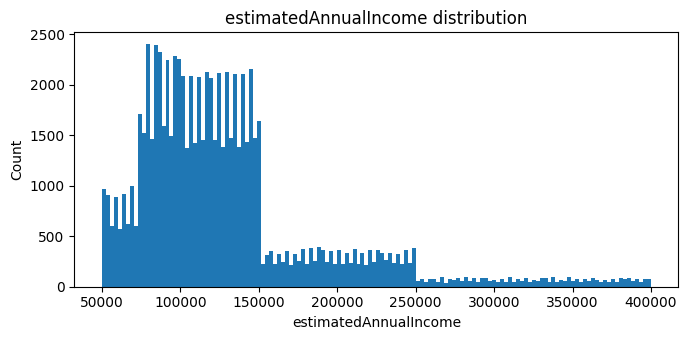


visitCount — n=100000, mean=2.23, std=2.07, min=1, 25%=1, 50%=1, 75%=3, max=10


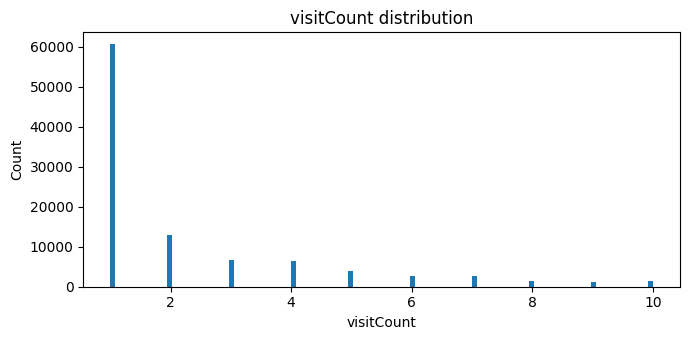


scrollDepth — n=100000, mean=62.3, std=30.1, min=0, 25%=50, 50%=75, 75%=75, max=100


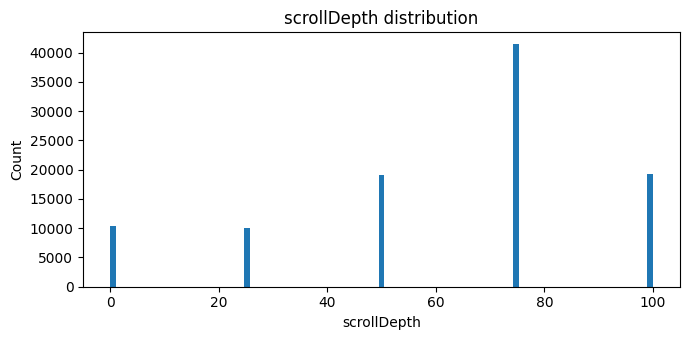

In [11]:
# Distributions for estimatedAnnualIncome, visitCount, scrollDepth


num_cols = ["estimatedAnnualIncome", "visitCount", "scrollDepth"]

for col in num_cols:
    if col not in df.columns:
        print(f"{col} not found; skipping.")
        continue

    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        print(f"{col}: no numeric values after coercion; skipping.")
        continue

    # Quick stats
    print(
        f"\n{col} — n={len(s)}, mean={s.mean():.3g}, std={s.std(ddof=1):.3g}, "
        f"min={s.min():.3g}, 25%={s.quantile(0.25):.3g}, "
        f"50%={s.median():.3g}, 75%={s.quantile(0.75):.3g}, max={s.max():.3g}"
    )

    # Histogram (linear x-axis)
    plt.figure(figsize=(7, 3.5))
    plt.hist(s, bins="auto")
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Optional: log-x version for heavily right-skewed, strictly positive data
    if (s > 0).all() and (s.max() / max(s.min(), 1e-12) > 100):
        plt.figure(figsize=(7, 3.5))
        plt.hist(s, bins="auto")
        plt.xscale("log")
        plt.title(f"{col} distribution (log x-axis)")
        plt.xlabel(f"{col} (log scale)")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()



### 3. Target Metric by CTA Copy & Placement
We evaluate **CTR (mean of `clickedCTA`)** across `ctaCopy` and `ctaPlacement`.

**Counts of `clickedCTA`**


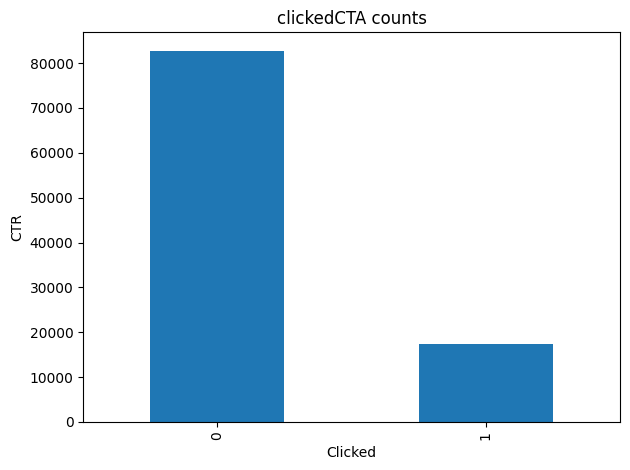

In [12]:
# Plot CTR by counts
plt.figure()
ctr_counts = df[target_col].value_counts()
ctr_counts.plot(kind="bar")
plt.title("clickedCTA counts")
plt.ylabel("CTR")
plt.xlabel("Clicked")
plt.tight_layout()

plt.show()

as we can see this is a highly imbalanced dataset as most visitors of the site do not intend to purchase a home immediately.

**exploring best `ctaCopy` and `ctaPlacement`**

In [13]:

alpha, min_n = 0.05, 30
group_cols = ["ctaCopy", "ctaPlacement"]

# summarize & choose best eligible combo
summary = (df.groupby(group_cols, dropna=False)[target_col]
             .agg(mean="mean", count="count")
             .reset_index())
best = summary.query("count >= @min_n").sort_values(["mean","count"], ascending=[False, False]).head(1)
if best.empty:
    raise ValueError(f"No groups meet min_n={min_n}")

best_copy, best_place = best.iloc[0][group_cols].tolist()

# split data
mask = (df["ctaCopy"] == best_copy) & (df["ctaPlacement"] == best_place)
x = df.loc[mask, target_col].dropna().to_numpy()
y = df.loc[~mask, target_col].dropna().to_numpy()

# Welch t-test, one-sided (best > rest) with fallback for older SciPy
t_stat, p = ttest_ind(x, y, equal_var=False, alternative="greater")


print(f"Best: copy='{best_copy}', placement='{best_place}' | n={len(x)} mean={x.mean():.4f}")
print(f"Rest: n={len(y)} mean={y.mean():.4f}")
print(f"Welch t (one-sided best>rest): t={t_stat:.3f}, p={p:.4g}")
print(f" -> Significant? {'YES' if p < alpha else 'NO'}")

# optional: keep your top-10 table
summary.sort_values("mean", ascending=False).head(10)


Best: copy='Get Pre-Approved for a Mortgage in 5 Minutes', placement='Top' | n=11112 mean=0.2118
Rest: n=88888 mean=0.1677
Welch t (one-sided best>rest): t=10.811, p=1.978e-27
 -> Significant? YES


,ctaCopy,ctaPlacement,mean,count
8,Get Pre-Approved for a Mortgage in 5 Minutes,Top,0.211753,11112
5,First Time? We've Made it Easy to Find the Bes...,Top,0.198452,11111
2,Access Your Personalized Mortgage Rates Now,Top,0.186482,11111
7,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,0.183332,11111
4,First Time? We've Made it Easy to Find the Bes...,Middle,0.169922,11111
1,Access Your Personalized Mortgage Rates Now,Middle,0.161462,11111
6,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,0.154172,11111
3,First Time? We've Made it Easy to Find the Bes...,Bottom,0.153092,11111
0,Access Your Personalized Mortgage Rates Now,Bottom,0.134821,11111


After running a t test to compare probability of click for each copy and placement combination, we can see that the best combo("Get Pre-Approv..." and Top) was measureably better over othe combinations when it came to improving CTR.

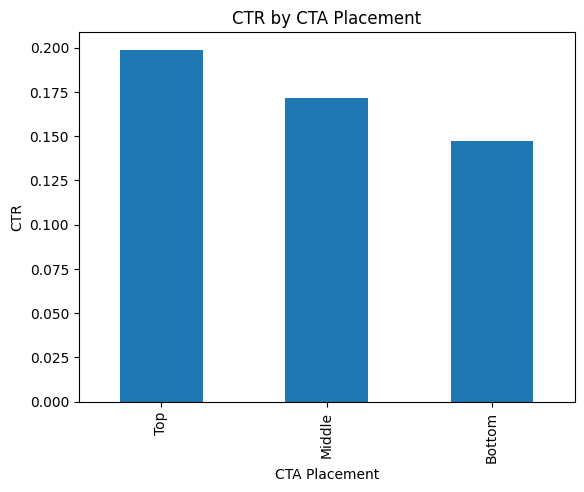

[Placement] Best='Top' | n=33334,66666 mean=0.1989,0.1595 | p=6.279e-52 -> Significant? YES





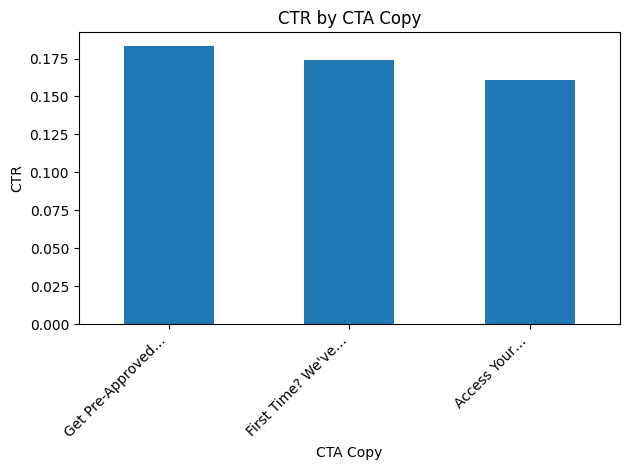

[Copy] Best='Get Pre-Approved for a Mortgage in 5 Minutes' | n=33334,66666 mean=0.1831,0.1674 | p=4.492e-10 -> Significant? YES


In [14]:


alpha, min_n = 0.05, 30

def best_vs_rest_ttest(df, col, y, label=None):
    g = (df.groupby(col, dropna=False)[y]
           .agg(mean="mean", count="count")
           .sort_values("mean", ascending=False))
    g = g[g["count"] >= min_n]
    if g.empty:
        print(f"[{label or col}] No group meets min_n={min_n}");
        return
    best = g.index[0]
    x = df.loc[df[col]==best, y].dropna().to_numpy()
    r = df.loc[df[col]!=best, y].dropna().to_numpy()
    t, p = ttest_ind(x, r, equal_var=False, alternative="greater")
    print(f"[{label or col}] Best='{best}' | n={len(x)},{len(r)} mean={x.mean():.4f},{r.mean():.4f} "
          f"| p={p:.4g} -> Significant? {'YES' if p < alpha else 'NO'}")


# Plot CTR by placement (aggregated over copy)
plt.figure()
placement_ctr = df.groupby("ctaPlacement")[target_col].mean().sort_values(ascending=False)
placement_ctr.plot(kind="bar")
plt.title("CTR by CTA Placement"); plt.ylabel("CTR"); plt.xlabel("CTA Placement")
plt.show()
best_vs_rest_ttest(df, "ctaPlacement", target_col, label="Placement")
print('\n\n')



# Plot CTR by copy (aggregated over placement) with shortened x-labels
plt.figure()
copy_ctr = df.groupby("ctaCopy")[target_col].mean().sort_values(ascending=False)
ax = copy_ctr.plot(kind="bar")
ax.set_xticklabels([textwrap.shorten(str(s), width=18, placeholder="…") for s in copy_ctr.index],
                   rotation=45, ha="right")
plt.title("CTR by CTA Copy"); plt.ylabel("CTR"); plt.xlabel("CTA Copy"); plt.tight_layout(); plt.show()
best_vs_rest_ttest(df, "ctaCopy",      target_col, label="Copy")


According to these the best placement is top and the best copy is "Get Pre-App..." when it comes to maximizing CTR of the CTA banner.


## 3. Leakage Audit
Columns that are **post-click** or downstream of the target (e.g., `submittedForm`, `scheduledAppointment`, `mortgageVariation`, `revenue`) are **excluded** from training features to avoid leaking future information.


In [15]:

# Identify columns
all_cols = df.columns.tolist()
post_click_cols = [c for c in all_cols if c.lower() in [
    "submittedform","scheduledappointment","mortgagevariation","revenue"
]]

# Target & identifier
id_col = "userId"

# Candidate features (exclude target, post-click, and id)
feature_cols = [c for c in all_cols if c not in set([target_col]) | set(post_click_cols) | set([id_col] if id_col else [])]

print("Excluded (post-click) columns:", post_click_cols)
print("Using features:", feature_cols)


Excluded (post-click) columns: ['submittedForm', 'scheduledAppointment', 'mortgageVariation', 'revenue']
Using features: ['date', 'sessionReferrer', 'browser', 'deviceType', 'estimatedAnnualIncome', 'estimatedPropertyType', 'visitCount', 'pageURL', 'ctaCopy', 'ctaPlacement', 'editorialSnippet', 'scrollDepth']



## 4. Feature Engineering Plan

- **Numeric:** `estimatedAnnualIncome`, `visitCount`, `scrollDepth` (scaled)
- **Categorical:** `sessionReferrer`, `browser`, `deviceType`, `estimatedPropertyType`, `ctaCopy`, `ctaPlacement` (one-hot)
- **Date:** `date` (converted to DOW and then one-hot).  
- **Text:** `editorialSnippet`,`pageURL` (target).  

I also experimented using `randomOverSampler` from `imblearn` to deal with the imbalanced nature of the dataset.

All steps are built into a single `sklearn`/`imblearn` **Pipeline** with a `ColumnTransformer`.


In [16]:
# sample only 5000 rows for experimenting only to speed things up
#comment out when ready
#df = df.sample(n=5000, random_state=RANDOM_STATE, replace=False).reset_index(drop=True)

In [17]:



numeric_features = ["estimatedAnnualIncome", "visitCount", "scrollDepth"]
categorical_features = ["sessionReferrer", "browser", "deviceType", "estimatedPropertyType", "ctaCopy", "ctaPlacement"]
date_features = ['date']
text_features = ['pageURL','editorialSnippet']

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)
print("datetime:", date_features)
print("Text:", text_features)


Numeric: ['estimatedAnnualIncome', 'visitCount', 'scrollDepth']
Categorical: ['sessionReferrer', 'browser', 'deviceType', 'estimatedPropertyType', 'ctaCopy', 'ctaPlacement']
datetime: ['date']
Text: ['pageURL', 'editorialSnippet']


In [18]:
# Preprocessors
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# for date convert to day of the week and one hot encode
def _date_to_dow_2d(X):
    s = pd.Series(np.asarray(X).ravel(), dtype="string").str.strip()
    s = s.replace("", pd.NA)  # treat empty as missing
    dt = pd.to_datetime(s, format="%m/%d/%y", errors="coerce")
    dow = dt.dt.day_name().fillna("(unknown)")
    return dow.to_numpy().reshape(-1, 1)

date_feature = "date" if "date" in df.columns else None
date_transformer = Pipeline(steps=[
    ("to_dow", FunctionTransformer(_date_to_dow_2d, validate=False)),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

#for larger text use target encoding
text_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("targetencode", TargetEncoder())
])

#oversampler to deal with imbalance
sampler = RandomOverSampler(sampling_strategy="auto", random_state=RANDOM_STATE)

#building preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("dow", date_transformer, date_features),
        ("text", text_transformer, text_features)
    ],
    remainder="drop",
    sparse_threshold=0.3
)


#models to compare and their hyperparameters to tune
model_params = {

    "logistic regression": {
        "model": LogisticRegression(solver="saga", max_iter=2000, n_jobs=None, random_state=RANDOM_STATE),
        "params": {
            "clf__C": [0.25, 0.5, 1.0],
            "clf__penalty":[None,'l1','l2']
        }
    },
    # Linear SVC (margin)
    "linear SVC": {
        "model": CalibratedClassifierCV(LinearSVC(dual=True, random_state=RANDOM_STATE),cv=3,method='sigmoid'),
        "params": {
            "clf__estimator__C": [0.25, 0.5, 1.0],
            "clf__estimator__class_weight": [None, "balanced"]
        }
    },
    "decision tree": {
        "model": DecisionTreeClassifier(random_state=RANDOM_STATE,class_weight='balanced'),
        "params": {
            "clf__max_depth": [3, 5, None],
            "clf__min_samples_leaf": [1, 5, 20],
            "clf__min_samples_split": [2, 10, 50],
        }
    },
    "random forest": {
        "model": RandomForestClassifier(n_estimators=300,random_state=RANDOM_STATE,bootstrap=True,class_weight='balanced'),
        "params": {
            "clf__max_depth": [5, 10, 15],
            "clf__min_samples_split": [5, 10, 20],
            "clf__min_samples_leaf": [5, 10, 20],
            "clf__max_features": ["sqrt", "log2"]
        }
    },
    "neural net (MLP)": {
        "model": Pipeline([
            ("nn", MLPClassifier(
                activation="relu",
                solver="adam",
                max_iter=200,
                early_stopping=True,
                n_iter_no_change=5,
                random_state=RANDOM_STATE
            ))
        ]),
        "params": {
            "clf__nn__hidden_layer_sizes": [(64,), (128,), (64, 32)],
            "clf__nn__alpha": [1e-4, 1e-3],
            "clf__nn__learning_rate_init": [1e-3, 5e-4]
        }
    },
    # Sanity baseline
    "dummy (prior)": {
        "model": DummyClassifier(strategy="prior", random_state=RANDOM_STATE),
        "params": {}
    }
}


## 5. Cross-Validation & Hyperparameter Tuning (Primary Metric: Log Loss)

**Model and preprocessing comparisons**
Here we will run a for loop comparing all the models, hyperparameters and sampling strategies to choose our best one.  

- We start with a test train validation split split
- Then tune hyperparameters on k fold cross validation with gridsearchCV on the training set.
- We also compare each optimal model with and without oversampling
- Some models do not output a probability score so for those we use isotonic regression to calibrate probabilities.  This is done on CalibratedClassifierCV.  It is important to align calibrations on seperate data from the models.  This is where the validation split from earlier comes in.
- Finally we choose our best model based on the one that minimizes log loss.


In [19]:
# Split the data into train and test sets (70/30)
X = df[feature_cols]
y = df[target_col].values
X_train_preval, X_test, y_train_preval, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
#seperate validation set for probability calibrations
X_train, X_val, y_train, y_val = train_test_split(X_train_preval, y_train_preval, stratify=y_train_preval, test_size=0.2, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)



scorers = {
    "neg_log_loss": "neg_log_loss",
    "roc_auc": "roc_auc",
    "average_precision": "average_precision"
}
results = []

for model_name, mp in model_params.items():
    for use_ros in (False, True):
        ros_mode = "Random oversampling" if use_ros else "no random oversampling"
        full_name = f"{model_name}"
        print(f"\nRunning GridSearchCV for {full_name} with {ros_mode}...")

        steps = [
            ("preprocessor", preprocessor),
            ("sampler", sampler if use_ros else "passthrough"), #random over sampling to treat imbalanced data
            ("clf", mp["model"]),
        ]
        pipeline = ImbPipeline(steps)

        grid = GridSearchCV(
            pipeline,
            param_grid=mp["params"],
            cv=cv,
            scoring="neg_log_loss",
            n_jobs=-1
        )

        # Training latency
        start_train = time.time()
        grid.fit(X_train, y_train)
        end_train = time.time()
        training_latency = end_train - start_train
        print('\ntraining time:',training_latency)

        best_model = grid.best_estimator_
        #add plat scaling to convert to a probability for all except logistic regression which is already scaled
        calibratedclf=CalibratedClassifierCV(best_model, method='isotonic', cv='prefit')
        calibratedclf.fit(X_val, y_val)
        best_model=calibratedclf

        # Probabilities for metrics
        proba_train = best_model.predict_proba(X_train)[:, 1]
        proba_test  = best_model.predict_proba(X_test)[:, 1]

        # Inference latency per sample (probabilities)
        start_infer = time.time()
        _ = best_model.predict_proba(X_test)
        inference_latency = (time.time() - start_infer) / len(X_test)

        # Train metrics
        train_ll  = log_loss(y_train, proba_train)
        train_roc = roc_auc_score(y_train, proba_train)
        train_ap  = average_precision_score(y_train, proba_train)
        # Test metrics
        test_ll  = log_loss(y_test, proba_test)
        test_roc = roc_auc_score(y_test, proba_test)
        test_ap  = average_precision_score(y_test, proba_test)

        # Model size
        model_size_kb = sys.getsizeof(pickle.dumps(best_model)) / 1024

        results.append({
            "Model": model_name,
            "random oversampling":use_ros,
            "CV best neg log loss": round(grid.best_score_, 6),  # higher (less negative) is better
            "Train log loss": round(train_ll, 6),
            "Test log loss": round(test_ll, 6),
            "Train ROC-AUC": round(train_roc, 6),
            "Test ROC-AUC": round(test_roc, 6),
            "Train average precision": round(train_ap, 6),
            "Test average precision": round(test_ap, 6),
            "Training Latency (s)": round(training_latency, 3),
            "Inference Latency (s/sample)": round(inference_latency, 6),
            "Storage Size (KB)": round(model_size_kb, 2),
            "Best Params": grid.best_params_
        })

results_df = pd.DataFrame(results).sort_values(
    by="Test log loss", ascending=True
).reset_index(drop=True)

display(results_df)
print("\nFinished GridSearchCV with preprocessing comparison.")



Running GridSearchCV for logistic regression with no random oversampling...

training time: 130.23901557922363


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for logistic regression with Random oversampling...

training time: 122.73219323158264


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for linear SVC with no random oversampling...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



training time: 75.83421683311462


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for linear SVC with Random oversampling...

training time: 118.75457239151001


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for decision tree with no random oversampling...

training time: 11.229022026062012


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for decision tree with Random oversampling...

training time: 14.06922197341919


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for random forest with no random oversampling...

training time: 324.1121737957001


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for random forest with Random oversampling...

training time: 535.1927196979523


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for neural net (MLP) with no random oversampling...

training time: 26.276275157928467


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for neural net (MLP) with Random oversampling...

training time: 99.74145221710205


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for dummy (prior) with no random oversampling...

training time: 0.9077444076538086


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Running GridSearchCV for dummy (prior) with Random oversampling...

training time: 0.869734525680542


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,Model,random oversampling,CV best neg log loss,Train log loss,Test log loss,Train ROC-AUC,Test ROC-AUC,Train average precision,Test average precision,Training Latency (s),Inference Latency (s/sample),Storage Size (KB),Best Params
0,neural net (MLP),False,-0.396610,0.389854,0.396624,0.754362,0.733752,0.347024,0.323001,26.276,0.000006,120.70,"{'clf__nn__alpha': 0.0001, 'clf__nn__hidden_la..."
1,random forest,True,-0.530361,0.312510,0.397339,0.921104,0.740964,0.716003,0.326836,535.193,0.000043,128433.65,"{'clf__max_depth': 15, 'clf__max_features': 's..."
2,neural net (MLP),True,-0.569416,0.382808,0.400273,0.775847,0.731184,0.368539,0.314371,99.741,0.000007,847.96,"{'clf__nn__alpha': 0.0001, 'clf__nn__hidden_la..."
3,random forest,False,-0.515637,0.326757,0.404426,0.898486,0.741517,0.633387,0.329210,324.112,0.000041,94230.37,"{'clf__max_depth': 15, 'clf__max_features': 's..."
4,decision tree,True,-0.605976,0.408629,0.410251,0.706476,0.699617,0.276269,0.271745,14.069,0.000003,742.05,"{'clf__max_depth': 5, 'clf__min_samples_leaf':..."
5,decision tree,False,-0.607507,0.408407,0.410376,0.706765,0.698595,0.276520,0.270747,11.229,0.000003,18.01,"{'clf__max_depth': 5, 'clf__min_samples_leaf':..."
6,logistic regression,True,-0.628308,0.420177,0.429440,0.701520,0.697597,0.281960,0.280086,122.732,0.000005,739.30,"{'clf__C': 0.5, 'clf__penalty': 'l2'}"
7,linear SVC,True,-0.628142,0.420770,0.429609,0.702237,0.698227,0.283491,0.280991,118.755,0.000005,741.00,"{'clf__estimator__C': 0.25, 'clf__estimator__c..."
8,logistic regression,False,-0.421802,0.421417,0.429676,0.703607,0.698510,0.288085,0.285039,130.239,0.000005,15.21,"{'clf__C': 1.0, 'clf__penalty': 'l2'}"
9,linear SVC,False,-0.422019,0.421733,0.430474,0.702359,0.698438,0.283064,0.280386,75.834,0.000005,16.77,"{'clf__estimator__C': 0.25, 'clf__estimator__c..."



Finished GridSearchCV with preprocessing comparison.


Now that we have our metrics for each configuration we tested, there are a few checks we should do here:

- make sure all models values were calculated and not nan
- check to make sure our models outperformed the sanity baseline(dummy).
- make sure that none of our models overfit.  We can check this by making sure that test metrics aren't too far from training metrics
- Make sure we don't have data leakage.  This can be checked by making sure test metrics aren't the same as training metrics.

Looks like our models passed the check!

In [20]:
# Display results
pd.set_option('display.max_colwidth', None)
pd.set_option("display.float_format", "{:.4f}".format)
print("\nModel Comparison Results:\n")
results_df


Model Comparison Results:



,Model,random oversampling,CV best neg log loss,Train log loss,Test log loss,Train ROC-AUC,Test ROC-AUC,Train average precision,Test average precision,Training Latency (s),Inference Latency (s/sample),Storage Size (KB),Best Params
0,neural net (MLP),False,-0.3966,0.3899,0.3966,0.7544,0.7338,0.3470,0.3230,26.2760,0.0000,120.7000,"{'clf__nn__alpha': 0.0001, 'clf__nn__hidden_layer_sizes': (64, 32), 'clf__nn__learning_rate_init': 0.001}"
1,random forest,True,-0.5304,0.3125,0.3973,0.9211,0.7410,0.7160,0.3268,535.1930,0.0000,128433.6500,"{'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5}"
2,neural net (MLP),True,-0.5694,0.3828,0.4003,0.7758,0.7312,0.3685,0.3144,99.7410,0.0000,847.9600,"{'clf__nn__alpha': 0.0001, 'clf__nn__hidden_layer_sizes': (128,), 'clf__nn__learning_rate_init': 0.001}"
3,random forest,False,-0.5156,0.3268,0.4044,0.8985,0.7415,0.6334,0.3292,324.1120,0.0000,94230.3700,"{'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5}"
4,decision tree,True,-0.6060,0.4086,0.4103,0.7065,0.6996,0.2763,0.2717,14.0690,0.0000,742.0500,"{'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}"
5,decision tree,False,-0.6075,0.4084,0.4104,0.7068,0.6986,0.2765,0.2707,11.2290,0.0000,18.0100,"{'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}"
6,logistic regression,True,-0.6283,0.4202,0.4294,0.7015,0.6976,0.2820,0.2801,122.7320,0.0000,739.3000,"{'clf__C': 0.5, 'clf__penalty': 'l2'}"
7,linear SVC,True,-0.6281,0.4208,0.4296,0.7022,0.6982,0.2835,0.2810,118.7550,0.0000,741.0000,"{'clf__estimator__C': 0.25, 'clf__estimator__class_weight': None}"
8,logistic regression,False,-0.4218,0.4214,0.4297,0.7036,0.6985,0.2881,0.2850,130.2390,0.0000,15.2100,"{'clf__C': 1.0, 'clf__penalty': 'l2'}"
9,linear SVC,False,-0.4220,0.4217,0.4305,0.7024,0.6984,0.2831,0.2804,75.8340,0.0000,16.7700,"{'clf__estimator__C': 0.25, 'clf__estimator__class_weight': 'balanced'}"



Since we are using log loss to choose our model, our experiments indicate the best model is a **Neural Nework** without random oversampling to deal with the imbalance.  This model is also fairly small and has low training latency.


## 6. Fit Final Model & Diagnostics

Here we will refit the best model on the training data and outpute visualizations for:

- ROC-AUC
- PR-AUC
- Calibration curve (to insure that the model is calibrated properly for outputting a probability)
- Brier score


Using best combo → Model: neural net (MLP) | Resampling: False
Best Params: {'clf__nn__alpha': 0.0001, 'clf__nn__hidden_layer_sizes': (64, 32), 'clf__nn__learning_rate_init': 0.001}


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


<Figure size 600x400 with 0 Axes>

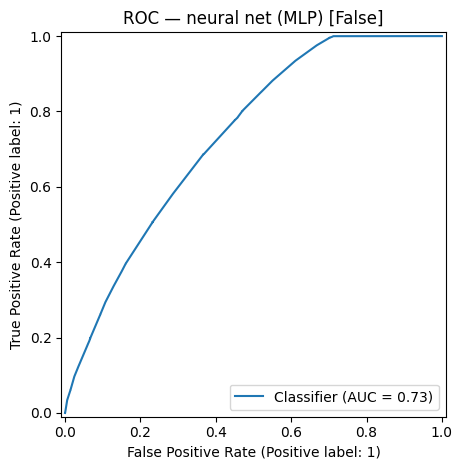

<Figure size 600x400 with 0 Axes>

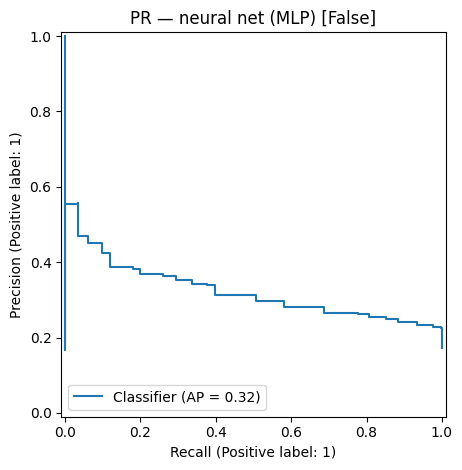

<Figure size 600x400 with 0 Axes>

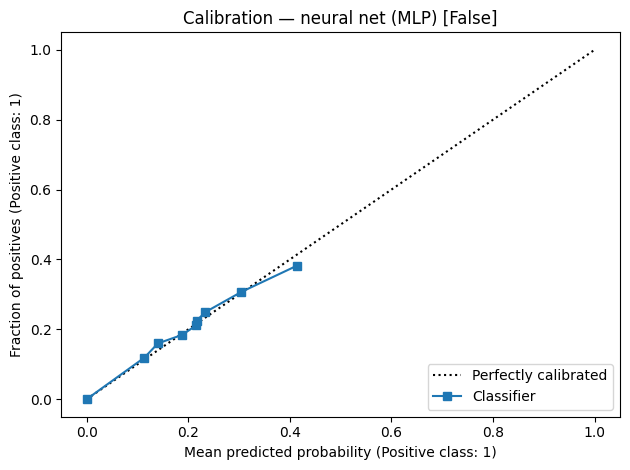

Brier: 0.12869452034744056


In [21]:
# Pick top combo from results_df and plot ROC / PR

# --- select the top row ---
top = results_df.iloc[0]
model_name   = top["Model"]
resampling   = top['random oversampling']  # column exists in the ROS/no-ROS sweep
best_params  = top["Best Params"]
if isinstance(best_params, str):  # if DataFrame stringified the dict
    try:
        best_params = ast.literal_eval(best_params)
    except Exception:
        best_params = {}

print(f"Using best combo → Model: {model_name} | Resampling: {resampling}")
print(f"Best Params: {best_params}")

# --- rebuild the pipeline with that combo ---
base_estimator = model_params[model_name]["model"]

steps = [
    ("preprocessor", preprocessor),
    ("sampler", sampler if resampling else "passthrough"),
    ("clf", base_estimator),
]
pipe = ImbPipeline(steps).set_params(**(best_params or {}))

# Some models (e.g., LinearSVC) don’t natively support predict_proba → calibrate
def needs_calibration(model):
    # Check the *base* estimator type; the pipeline itself won’t expose predict_proba before fit
    return not hasattr(model, "predict_proba")

est = pipe
est.fit(X_train, y_train)
calibratedclf=CalibratedClassifierCV(est, method='isotonic', cv='prefit')
calibratedclf.fit(X_val, y_val)
est=calibratedclf

# --- fit & score ---

y_score = est.predict_proba(X_test)[:, 1]

# --- plots ---
#roc curve
plt.figure(figsize=(6,4))
RocCurveDisplay.from_predictions(y_test, y_score)
plt.title(f"ROC — {model_name} [{resampling}]")
plt.tight_layout()
plt.show()

#pr curve
plt.figure(figsize=(6,4))
PrecisionRecallDisplay.from_predictions(y_test, y_score)
plt.title(f"PR — {model_name} [{resampling}]")
plt.tight_layout()
plt.show()


# --- calibration (reliability) curve ---
plt.figure(figsize=(6,4))
CalibrationDisplay.from_predictions(y_test, y_score, n_bins=10, strategy="quantile")
plt.title(f"Calibration — {model_name} [{resampling}]")
plt.tight_layout()
plt.show()


print("Brier:", brier_score_loss(y_test, y_score))


The ROC and PR curves seem reasonable given the imbalanced data, especially when comparing against the baseline.  The calibration curve is well calibrated with a brier score of just 0.12.


## 7. Submission Writer
Creates `Yampolsky_predictions.csv` with columns `userId, pr_CTA`.

Change the folder/file paths if you're on local/have a different google drive file structure.


In [22]:


def make_submission(name, data_frame):
    """
    Parameters:
    -----------
        name:               string, your name
        data_frame:         pandas DataFrame [20000, 2], userId and
                                predicted probabilities on the test set
    """
    cnames = data_frame.columns.values
    if not isinstance(data_frame, pd.DataFrame):
        raise ValueError('Expecting a pandas DataFrame for argument 2')
    elif cnames[0] != 'userId':
        raise ValueError('Column name 0 incorrect, expecting userId, received ' + cnames[0])

    t0 = time()
    filename = name + '.csv'
    data_frame.to_csv(filename, index = False)
    return '{fname} written in {t:.{rd}f} ms'.format(fname = filename, t = (time() - t0) / 1000., rd = 3)

In [25]:
# Fit best model on ALL data, predict on Google Drive test.csv, save predictions back to Drive


# 1) Mount Google Drive
#if running on local change the file paths.

test_path = os.path.join(GDRIVE_FOLDER, "test.csv")
out_path  = os.path.join(GDRIVE_FOLDER, "Yampolsky_predictions")

assert os.path.exists(test_path), f"test.csv not found at: {test_path}"

# 2) Pick best row from results_df (assumes you've sorted it already to your preferred metric)
top = results_df.iloc[0]
model_name  = top["Model"]
resampling  = top["Resampling"] if "Resampling" in results_df.columns else "no-ROS"
best_params = top["Best Params"]
if isinstance(best_params, str):
    try:
        best_params = ast.literal_eval(best_params)
    except Exception:
        best_params = {}

print(f"Refitting best on full data → Model: {model_name} | Resampling: {resampling}")
print(f"Best Params: {best_params}")

# 3) Rebuild pipeline with that combo
base_model = clone(model_params[model_name]["model"])
steps = [
    ("preprocessor", preprocessor),
    ("sampler", sampler if str(resampling).lower() == "ros" else "passthrough"),
    ("clf", base_model),
]
pipe = ImbPipeline(steps).set_params(**(best_params or {}))

# Wrap in calibration only if final estimator lacks predict_proba (e.g., LinearSVC)
needs_calibration = not hasattr(base_model, "predict_proba")
est_full = CalibratedClassifierCV(pipe, method="isotonic", cv=3)

# 4) Fit on ALL available labeled data
X_full = df[feature_cols]
y_full = df[target_col].values
est_full.fit(X_full, y_full)

# 5) Load test.csv from Drive and align columns
test_df = pd.read_csv(test_path)
missing = [c for c in feature_cols if c not in test_df.columns]
for c in missing:
    test_df[c] = np.nan
X_test_final = test_df[feature_cols]


# 6) Predict probabilities and save to Drive
pr = est_full.predict_proba(X_test_final)[:, 1]
pred_df = pd.DataFrame({"userId": test_df['userId'], "pr_CTA": pr})


make_submission(out_path, pred_df)
print(f"Saved predictions to: {out_path}.csv")

# (optional) also save the fitted model for reuse
model_out = os.path.join(GDRIVE_FOLDER, "best_model_full.joblib")
joblib.dump(est_full, model_out)
print(f"Saved fitted model to: {model_out}")


Refitting best on full data → Model: neural net (MLP) | Resampling: no-ROS
Best Params: {'clf__nn__alpha': 0.0001, 'clf__nn__hidden_layer_sizes': (64, 32), 'clf__nn__learning_rate_init': 0.001}
Saved predictions to: /content/drive/MyDrive/Colab Notebooks/Yampolsky_predictions.csv
Saved fitted model to: /content/drive/MyDrive/Colab Notebooks/best_model_full.joblib


## Part 2
### Questions


###Q1. What key metrics evaluate CTA combinations, and which copy/placement did best/worst?

The metrics we can use are mean of `clickedCTA`, `submittedForm`, `scheduledAppointment`, and `revenue`

At the end of the day increasing revenue will be a businesses primary concern.  An increase in click through rate might sound promising, but it could also be an indicator that the cta banner was odd and people only clicked it out of curiosity.  Revenue will be the gold standard for measuring sales impact.

In [26]:

# distributions of ctr for each combination of ctacopy and ctaplacement
group_cols = ["ctaCopy", "ctaPlacement"]
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce").fillna(0.0)

summary = (df.groupby(group_cols)["revenue"]
             .agg(["mean","std","count","sum"])
             .reset_index()
             .sort_values("mean", ascending=False)
             .reset_index(drop=True))
display(summary)

best_row = summary.iloc[0]
best_placement, best_copy = best_row["ctaPlacement"], best_row["ctaCopy"]

mask_best = (df["ctaPlacement"]==best_placement) & (df["ctaCopy"]==best_copy)
best_revs = df.loc[mask_best, "revenue"].to_numpy()
rest_revs = df.loc[~mask_best, "revenue"].to_numpy()

# Mann–Whitney U (one-sided best>rest)
u_stat, p_mw = mannwhitneyu(best_revs, rest_revs, alternative="greater")

# Welch t-test (one-sided best>rest) with fallback for older SciPy
t_stat, p_t = ttest_ind(best_revs, rest_revs, equal_var=False, alternative="greater")


print(f"Best combo: placement='{best_placement}', copy='{best_copy}'")
print(f"n_best={best_revs.size}, n_rest={rest_revs.size}")
print(f"Mean rev/imp (best)={best_revs.mean():.6f} | (rest)={rest_revs.mean():.6f}")
print(f"Mann–Whitney U p(one-sided)={p_mw:.6g} -> {'Significant' if p_mw<0.05 else 'Not significant'} at α=0.05")
print(f"Welch t-test p(one-sided)={p_t:.6g}     -> {'Significant' if p_t<0.05 else 'Not significant'} at α=0.05")


,ctaCopy,ctaPlacement,mean,std,count,sum
0,First Time? We've Made it Easy to Find the Best Mortgage Rate,Bottom,12.9052,54.5715,11111,143390.0000
1,Get Pre-Approved for a Mortgage in 5 Minutes,Top,12.6809,52.0460,11112,140910.0000
2,First Time? We've Made it Easy to Find the Best Mortgage Rate,Top,12.2869,52.9500,11111,136520.0000
3,Access Your Personalized Mortgage Rates Now,Top,12.1209,52.8946,11111,134675.0000
4,First Time? We've Made it Easy to Find the Best Mortgage Rate,Middle,12.0714,52.7253,11111,134125.0000
5,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,11.7537,49.2534,11111,130595.0000
6,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,11.6974,49.6325,11111,129970.0000
7,Access Your Personalized Mortgage Rates Now,Middle,11.4243,51.7516,11111,126935.0000
8,Access Your Personalized Mortgage Rates Now,Bottom,11.3325,50.7523,11111,125915.0000


Best combo: placement='Bottom', copy='First Time? We've Made it Easy to Find the Best Mortgage Rate'
n_best=11111, n_rest=88889
Mean rev/imp (best)=12.905229 | (rest)=11.920991
Mann–Whitney U p(one-sided)=0.163048 -> Not significant at α=0.05
Welch t-test p(one-sided)=0.0356794     -> Significant at α=0.05


In terms of which copy and placement combination performed best overall, its "First Time? We..." with bottom placement as this combination returned the highest revenue.  It was significant for the one-sided t-test but not the Mann-Whitney test .


I then also compare ctaCopy to see if one was significantly better as well.

In [27]:
# distributions of ctr for each combination of ctacopy and ctaplacement
group_cols = ["ctaCopy"]
df['revenue'] = pd.to_numeric(df['revenue'], errors="coerce").fillna(0.0)
summary = (
    df.groupby(group_cols)['revenue']
    .agg(["mean","std","count","sum"])
    .reset_index()
    .sort_values("mean", ascending=False)
    .reset_index(drop=True)
)


display(summary)

best_row = summary.iloc[0]  # ← choose best via iloc
best_copy = best_row["ctaCopy"]

d=df.copy()
# Raw samples: best vs rest
mask_best =  (d["ctaCopy"] == best_copy)

best_revs = d.loc[mask_best, "revenue"].to_numpy()
rest_revs = d.loc[~mask_best, "revenue"].to_numpy()


# One-sided test: H1 = best_placement > others
u_stat, p_value = mannwhitneyu(best_revs, rest_revs, alternative="greater")
t_stat, p_t = ttest_ind(best_revs, rest_revs, equal_var=False, alternative="greater")

print(f"Best copy (via summary.iloc[0]): {best_copy}")
print(f"n_best={best_revs.size}, n_rest={rest_revs.size}")
print(f"Mean revenue/impression (best): {best_revs.mean():.6f}")
print(f"Mean revenue/impression (rest): {rest_revs.mean():.6f}")
print(f"Mann–Whitney U p(one-sided)={p_mw:.6g} -> {'Significant' if p_mw<0.05 else 'Not significant'} at α=0.05")
print(f"Welch t-test p(one-sided)={p_t:.6g}     -> {'Significant' if p_t<0.05 else 'Not significant'} at α=0.05")

,ctaCopy,mean,std,count,sum
0,First Time? We've Made it Easy to Find the Best Mortgage Rate,12.4212,53.4215,33333,414035.0000
1,Get Pre-Approved for a Mortgage in 5 Minutes,12.0440,50.3264,33334,401475.0000
2,Access Your Personalized Mortgage Rates Now,11.6259,51.8065,33333,387525.0000


Best copy (via summary.iloc[0]): First Time? We've Made it Easy to Find the Best Mortgage Rate
n_best=33333, n_rest=66667
Mean revenue/impression (best): 12.421174
Mean revenue/impression (rest): 11.834941
Mann–Whitney U p(one-sided)=0.163048 -> Not significant at α=0.05
Welch t-test p(one-sided)=0.0484761     -> Significant at α=0.05


"First Time? We've m..." performed better on average. It was significant for the t-test but not the Mann-Whitney.


T-test and Mann-Whitney tests measure two different things.  t-test measure a difference in the means of two distributions and Mann-Whitney measures if the rankings of items are different.  Ultimately if we are trying to measure mean revenue/impression than the t test is what we care most about.  This indicates one combination is significantly better and should be chosen.  The reason t-test is significant but not Mann-Whitney is likely due to a very heavy right tail as most users do not end up purchasing a home.  Since all the 0's are equally ranked, it won't make the distributions seem different.

  Given these results I would recommend our champion as **First Time? We've m..."** with **bottom** placement as it was **statistically significant** at improving `revenue`.

### Q2. Which groups of people are more/less correlated with the key metrics?

This is a really great question and can allow us to answer the question of which placement and copy combination to use in a less naive manner.  It would often be the case that the best combination is different for different groups.  There are many ways we can segment people.  

1. One option is to use an unsupervised clustering algorithm to cluster people. We can then if one combination is significantly better for any specific cluster.
2. we can segment the data by the different `ctaCopy` and `ctaPlacement` combinations and then train a simple model like logistic regression.  The weights of each term in the model will signify which groups and values are more strongly associated with the key metrics.
3. We can use lift to measure if any categorical features are linked to the key metrics.

In the interest of time I outputted the third option just to show how it can be done.

In [28]:

# --- pick the key metric (prefer revenue per impression; else CTR) ---
if "revenue" in d.columns:
    d["metric"] = pd.to_numeric(d["revenue"], errors="coerce").fillna(0.0)
    metric_label = "Revenue per impression"
else:
    target_col = next((c for c in d.columns if c.lower() == "clickedcta"), None)
    assert target_col is not None, "clickedCTA not found and no revenue column."
    d["metric"] = pd.to_numeric(d[target_col], errors="coerce").fillna(0).astype(float)
    metric_label = "CTR"

# helpful extra segment: day-of-week from `date`, if available
if "date" in d.columns:
    d["dayOfWeek"] = pd.to_datetime(d["date"], errors="coerce").dt.day_name().fillna("(unknown)")

# define segment columns (keep only those that exist)
cat_cols = [c for c in ["deviceType","browser","sessionReferrer","estimatedPropertyType","dayOfWeek"] if c in d.columns]
num_cols = [c for c in ["estimatedAnnualIncome","visitCount","scrollDepth"] if c in d.columns]

# fill missing categories with a label
for c in cat_cols:
    d[c] = d[c].astype(str).fillna("(missing)")

baseline = d["metric"].mean()
min_n = 50  # ignore tiny groups

def summarize_cat(col, top_k=5):
    s = (
        d.groupby(col, dropna=False)["metric"]
         .agg(mean="mean", n="size", total="sum", std="std")
         .reset_index()
    )
    s["std"] = s["std"].fillna(0.0)
    s["lift_abs"] = s["mean"] - baseline
    s["lift_rel_%"] = np.where(baseline > 0, 100 * s["lift_abs"] / baseline, np.nan)
    s = s.sort_values("mean", ascending=False)
    eligible = s.query("n >= @min_n").copy()
    print(f"\n=== {col} — best/worst by {metric_label} (n ≥ {min_n}) ===")
    if eligible.empty:
        print("No groups with enough samples.")
        return
    display(eligible.head(top_k))

# --- categorical groups: show who is higher/lower than baseline ---
print(f"Baseline {metric_label}: {baseline:.6f}")
for c in cat_cols:
    summarize_cat(c, top_k=5)

# --- numeric features: Spearman correlation with the metric ---
if num_cols:
    rows = []
    # Ensure metric is numeric and median-imputed
    m = pd.to_numeric(d["metric"], errors="coerce")
    if m.isna().any():
        m = m.fillna(m.median())

    for c in num_cols:
        x = pd.to_numeric(d[c], errors="coerce")

        # median-impute feature
        x = x.fillna(x.median())

        # Spearman on all rows now that both series are imputed
        rho, p = spearmanr(x, m)
        rows.append({"feature": c, "spearman_rho": rho, "p_value": p, "n": int(len(x))})

    num_corr = pd.DataFrame(rows).sort_values("spearman_rho", ascending=False)
    print("\n=== Numeric feature correlations with key metric (Spearman, median-imputed) ===")
    display(num_corr)



Baseline Revenue per impression: 12.030350

=== deviceType — best/worst by Revenue per impression (n ≥ 50) ===


/tmp/ipython-input-873043395.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["dayOfWeek"] = pd.to_datetime(d["date"], errors="coerce").dt.day_name().fillna("(unknown)")


,deviceType,mean,n,total,std,lift_abs,lift_rel_%
0,Desktop,14.3836,39966,574855.0000,56.4333,2.3533,19.5610
1,Mobile,10.4637,60034,628180.0000,48.5276,-1.5666,-13.0222



=== browser — best/worst by Revenue per impression (n ≥ 50) ===


,browser,mean,n,total,std,lift_abs,lift_rel_%
2,Firefox,13.9956,7930,110985.0000,55.4303,1.9652,16.3357
1,Edge,13.2351,2986,39520.0000,53.8485,1.2047,10.0142
0,Chrome,12.1312,41108,498690.0000,52.1381,0.1009,0.8384
3,Safari,11.5441,47976,553840.0000,50.8830,-0.4862,-4.0418



=== sessionReferrer — best/worst by Revenue per impression (n ≥ 50) ===


,sessionReferrer,mean,n,total,std,lift_abs,lift_rel_%
0,Direct,17.1043,17745,303515.0000,61.2799,5.0739,42.1759
1,Email,15.5622,16463,256200.0000,58.5797,3.5318,29.3576
2,Google,10.5485,57023,601505.0000,48.7380,-1.4819,-12.3179
3,Social,4.7685,8769,41815.0000,32.3864,-7.2618,-60.3627



=== estimatedPropertyType — best/worst by Revenue per impression (n ≥ 50) ===


,estimatedPropertyType,mean,n,total,std,lift_abs,lift_rel_%
0,Apartment,13.5460,33402,452465.0000,52.9900,1.5157,12.5989
3,Townhome,11.5054,10964,126145.0000,50.2267,-0.5250,-4.3637
1,House,11.2895,52966,597960.0000,51.9163,-0.7408,-6.1581
2,Mobile Home,9.9194,2668,26465.0000,41.9693,-2.1109,-17.5467



=== dayOfWeek — best/worst by Revenue per impression (n ≥ 50) ===


,dayOfWeek,mean,n,total,std,lift_abs,lift_rel_%
4,Thursday,12.1884,13359,162825.0000,52.0234,0.1581,1.3139
6,Wednesday,12.1707,13491,164195.0000,52.4078,0.1404,1.1667
2,Saturday,12.1253,13210,160175.0000,51.8373,0.0949,0.7891
1,Monday,12.0803,16875,203855.0000,52.1922,0.0499,0.4152
5,Tuesday,12.0489,13095,157780.0000,52.4110,0.0185,0.1540



=== Numeric feature correlations with key metric (Spearman, median-imputed) ===


,feature,spearman_rho,p_value,n
2,scrollDepth,0.1064,0.0000,100000
1,visitCount,0.0329,0.0000,100000
0,estimatedAnnualIncome,-0.0108,0.0006,100000


For categorical features the best groups are those with the highest lift.  Lift is a measure of how much higher the mean of the group is with respect to the baseline.  The most impactful group are those referred **directly** or by **email**.

For numerical features we can either bin them in groups and observe lift in the same way or we can simply use the correlation coeficient. According to this the best feature is `scrollDepth` which makes sense as those who spend the most time scrolling probably are the ones most interested in buying a house.


### Q3. Feature engineering ideas to increase predictive power:
In my experiments I only tried one preprocessing strategy, but normally I would use a for loop to compare several.

Here are some additional ideas about how we can engineer features:
- **Text**: TF–IDF on `editorialSnippet` and normalized `pagePath`.  
- **Interactions**: `ctaCopy × ctaPlacement`, `deviceType × scrollDepth`.  
- **URL features**: Extract product/topic slugs from `pageURL` paths.  
- **Recency/engagement**: If timestamps available (not in this dataset), derive hour/day-of-week.
- **Holiday/time of year**: Many people prefer to purchase homes in November as there is less competition for buyers.
- **Dropping features using Shapley**: Shapley values can be used to get feature importance.  If any features have no effect on the model, it might be optimal to retrain the model with the features dropped.  Redundant features can often confuse the model and lead to overfitting.

### Q4. Beyond Log Loss, what else and why?
Log loss is a great metric as it puts a higher penalty on the model being too confident when its wrong.  There are several other useful metrics for classification models.
- **f1 score** is great because it puts an equal weight to both classes.  This can be useful for imbalanced datasets such as this one.
- **ROC-AUC** (ranking ability), **PR-AUC** (useful under class imbalance), and **Calibration** checks (reliability curves).  
- **Brier score** To make sure results are calibrated well as probabilities.





## Optional Questions:

### 1. What additional predictive model would you build to inform which CTA combinations would maximize the revenue in addition to predict clickedCTA, and why?
I would do something very similar to what I have done with `clickedCTA` except with revenue as my target variable.  Since this would change our problem from classification to regression, we would have to avoid certain models like logistic regression and SVM.

I think to predict revenue I would use `linear regression`, `polynomial regression`, `decision tree`, `xgboost`, `random forest`, and `ANN`.

I would try that with different segmentation splits as well as use shapley to analyze which groups lead to the best returns.

### 2. If we called one of these CTA combinations our champion(served it 100% of the time), how much incrementally is that worth to use v.s. the average of the rest of the split test?

This is very similar to question 1 of part 2,

The best combination to use overall is:

CTA Copy: **'First Time? We've Made it Easy to Find the Best Mortgage Rate'**

CTA Placement: **Bottom**

To calculate the incremental worth of that decision we can do the following:


In [29]:
# Champion vs. rest — incremental value (revenue per impression)


d["revenue"] = pd.to_numeric(d["revenue"], errors="coerce").fillna(0.0)
for c in ["ctaCopy", "ctaPlacement"]:
    d[c] = d[c].astype(str).fillna("(missing)")

group_cols = ["ctaCopy", "ctaPlacement"]
g = (
    d.groupby(group_cols)["revenue"]
     .agg(rev_mean="mean", rev_sum="sum", n="size")
     .reset_index()
)

min_n = 50  # ignore tiny cells
eligible = g[g["n"] >= min_n].copy()
assert not eligible.empty, "No eligible CTA combos with sufficient volume."

# champion = highest revenue per impression among eligible combos
champ = eligible.loc[eligible["rev_mean"].idxmax()]
champ_key = (champ["ctaCopy"], champ["ctaPlacement"])

# rest = impression-weighted average of all other eligible combos
rest = eligible[(eligible["ctaCopy"] != champ_key[0]) | (eligible["ctaPlacement"] != champ_key[1])]
rest_rev_mean = (rest["rev_sum"].sum() / rest["n"].sum()) if rest["n"].sum() > 0 else np.nan

lift_per_impr = champ["rev_mean"] - rest_rev_mean
rpm_lift = 1000 * lift_per_impr  # lift per 1,000 impressions

print(f"Champion: copy='{champ_key[0]}', placement='{champ_key[1]}' (n={int(champ['n'])})")
print(f"Champion revenue/imp: {champ['rev_mean']:.6f}")
print(f"Rest (weighted) revenue/imp: {rest_rev_mean:.6f}")
print(f"Incremental per impression: {lift_per_impr:.6f}")
print(f"Incremental per 1,000 impressions (RPM lift): ${rpm_lift:,.2f}")

# Optional: estimate total incremental revenue for a traffic plan
future_impressions = 100_000  # ← set this to your expected volume
print(f"Estimated incremental revenue for {future_impressions:,} impressions: ${future_impressions * lift_per_impr:,.2f}")


Champion: copy='First Time? We've Made it Easy to Find the Best Mortgage Rate', placement='Bottom' (n=11111)
Champion revenue/imp: 12.905229
Rest (weighted) revenue/imp: 11.920991
Incremental per impression: 0.984238
Incremental per 1,000 impressions (RPM lift): $984.24
Estimated incremental revenue for 100,000 impressions: $98,423.77


## Thank you
for taking the time to read my notebook.  I really enjoyed the assignment.  I appreciate the opportunity and look forward to hearing from you.

Best regards,
Greg

In [30]:
print("Thanks! \\(^o^)/")

Thanks! \(^o^)/
